# Face detection and recognition training pipeline

The following example illustrates how to fine-tune an InceptionResnetV1 model on your own dataset. This will mostly follow standard pytorch training patterns.

In [24]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import numpy as np
import os

#### Define run parameters

The dataset should follow the VGGFace2/ImageNet-style directory layout. Modify `data_dir` to the location of the dataset on wish to finetune on.

In [25]:
data_dir = '../data/test_images'

batch_size = 32
epochs = 8
workers = 0 if os.name == 'nt' else 8

#### Determine if an nvidia GPU is available

In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


#### Define MTCNN module

See `help(MTCNN)` for more details.

In [27]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

#### Perfom MTCNN facial detection

Iterate through the DataLoader object and obtained cropped faces.

In [28]:
dataset = datasets.ImageFolder(data_dir, transform=transforms.Resize((512, 512)))
dataset.samples = [
    (p, p.replace(data_dir, data_dir + '_cropped'))
        for p, _ in dataset.samples
]
        
loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=training.collate_pil
)

for i, (x, y) in enumerate(loader):
    mtcnn(x, save_path=y)
    print('\rBatch {} of {}'.format(i + 1, len(loader)), end='')
    
# Remove mtcnn to reduce GPU memory usage
del mtcnn

Batch 1 of 1

#### Define Inception Resnet V1 module

See `help(InceptionResnetV1)` for more details.

In [29]:
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=len(dataset.class_to_idx)
).to(device)

#### Define optimizer, scheduler, dataset, and dataloader

In [30]:
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])
dataset = datasets.ImageFolder(data_dir + '_cropped', transform=trans)
img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)
train_inds = img_inds[:int(0.8 * len(img_inds))]
val_inds = img_inds[int(0.8 * len(img_inds)):]

train_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_inds)
)
val_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(val_inds)
)

#### Define loss and evaluation functions

In [11]:
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

#### Train model

In [12]:
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
resnet.eval()
training.pass_epoch(
    resnet, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet.eval()
    training.pass_epoch(
        resnet, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()



Initial
----------
Valid |     1/1    | loss:    1.5646 | fps:    0.5583 | acc:    0.0000   

Epoch 1/8
----------
Train |     1/1    | loss:    2.0275 | fps:   11.7710 | acc:    0.0000   
Valid |     1/1    | loss:    2.0614 | fps:    4.0331 | acc:    0.0000   

Epoch 2/8
----------
Train |     1/1    | loss:    0.3560 | fps:   12.3326 | acc:    1.0000   
Valid |     1/1    | loss:    2.5922 | fps:    4.2945 | acc:    0.0000   

Epoch 3/8
----------
Train |     1/1    | loss:    0.0385 | fps:   12.7815 | acc:    1.0000   
Valid |     1/1    | loss:    3.1188 | fps:    4.1652 | acc:    0.0000   

Epoch 4/8
----------
Train |     1/1    | loss:    0.0093 | fps:   12.6630 | acc:    1.0000   
Valid |     1/1    | loss:    3.3721 | fps:    4.2773 | acc:    0.0000   

Epoch 5/8
----------
Train |     1/1    | loss:    0.0024 | fps:   12.8166 | acc:    1.0000   
Valid |     1/1    | loss:    3.3138 | fps:    4.2685 | acc:    0.0000   

Epoch 6/8
----------
Train |     1/1    | loss:    0.0

In [50]:
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image

img = Image.open("../data/test_images_cropped/kate_siegel/1.jpg")

# If required, create a face detection pipeline using MTCNN:
mtcnn = MTCNN(image_size=160, margin=0)

# Create an inception resnet (in eval mode):
resnet = InceptionResnetV1(pretrained='vggface2').eval()

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])

img_cropped = trans(img)
# img_cropped = mtcnn(img)

In [51]:
# Calculate embedding (unsqueeze to add batch dimension)
img_embedding = resnet(img_cropped.unsqueeze(0))

# Or, if using for VGGFace2 classification
resnet.classify = True
img_probs = resnet(img_cropped.unsqueeze(0))

In [52]:
img_probs

tensor([[ 2.9813,  1.0381,  1.4535,  ..., -0.9572, -0.0984,  1.1482]],
       grad_fn=<AddmmBackward>)

In [53]:
img_probs.size()

torch.Size([1, 8631])

In [54]:
img_embedding.size()

torch.Size([1, 512])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


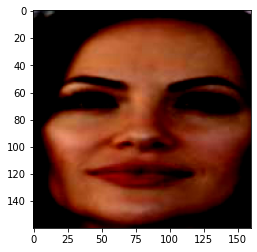

In [55]:
import matplotlib.pyplot as plt
plt.imshow(img_cropped.numpy().transpose(1,2,0))

In [18]:
dataset.samples[0]

('../data/test_images/angelina_jolie/1.jpg',
 '../data/test_images_cropped/angelina_jolie/1.jpg')

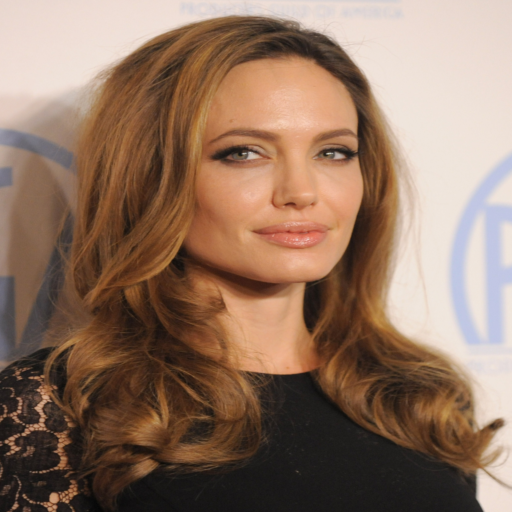

In [20]:
x = dataset.__getitem__(0)[0]

In [42]:
a = next(iter(val_loader))

In [43]:
len(a)

2

In [44]:
a[0].shape

torch.Size([1, 3, 160, 160])

In [45]:
a[1].shape

torch.Size([1])

In [46]:
a[1]

tensor([0])

In [48]:
train_inds

array([4, 1, 2, 3])

In [49]:
val_inds

array([0])